### Derivation

Let's start from the constitutive equation for elasticity and the constitutive equation for a Maxwell rheology. We'll do this in full 3D complexity and then reduce to plane-strain later.

$$\textrm{Elastic:  }~~ \sigma_{ij} = 2\mu\epsilon_{ij} + \lambda\epsilon_{kk}\delta_{ij}$$
$$\textrm{Maxwell:  }~~ \dot{\sigma}_{ij} + \frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij}) = 2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}$$

And Newton's law:

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = f_i $$

So, for an elastic rheology:

$$ \frac{\partial [2\mu\epsilon_{ij} + \lambda\epsilon_{kk}\delta_{ij}]}{\partial x_j} = f_i $$

For a viscoelastic rheology, remembering the time derivative: $\dot{\sigma}_{ij}$:

$$ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij} - [\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]\big]}{\partial x_j} = \dot{f}_i $$

Rearranging the viscoelastic equation: 

$$ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}\big]}{\partial x_j} = \dot{f}_i  + \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} $$

Rewriting the right hand side as $F_i$, we see that this is an elastic problem with a funny body force:

$$ \textrm{"Elastic-like": }~~ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}\big]}{\partial x_j} = F_i$$
$$ \textrm{"Viscoelastic body force": }~~ F_i = \dot{f}_i + \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} $$

It's important to notice that in the main "Elastic-like" equation, we are operating in terms of velocity/strain-rate/stressing-rate because the whole equation has had a time derivative applied. 

So, how do we solve this? I see two broad ways depending on where we would prefer to do the time integration. 

1. Compute velocities and stressing rates at each time step and then integrate those to obtain displacement and stress. 
2. Integrate the "Elastic-like" equation analytically (trivial, since it just involves removing some dots), so that we can solve directly for displacement and stress then do a time integration to compute the current viscoelastic body force. 

I think method #2 is likely to be more accurate and stable simply because it involves lower order derivatives. Instead of integrating stressing rate in time to get stress, we are integrating stress in time to get the total viscoelastic body force. To do this, let's define:

$$ V = \int_{0}^{t}\frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} dt $$

and rearrange this to involve a time step:

$$ V^{n+1}_i = V^{n}_i + \int_{t^n}^{t^{n+1}} \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} dt$$

Returning to the main law of motion:

$$\frac{\partial \sigma_{ij}^{n}}{\partial x_j} = f^{n}_i + V^{n}_i$$

So, what's the final solution procedure?

1. Given $V_i^n$, solve the law of motion for stress, $\sigma_{ij}$, and displacement $u_i$.
2. Now, integrate the time step equation above to get $V_i^{n+1}$. 

In [1]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall
using FEniCS

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866
┌ Warning: Package FEniCS does not have PyPlot in its dependencies:
│ - If you have FEniCS checked out for development and have
│   added PyPlot as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FEniCS
│ Loading PyPlot into FEniCS from project dependency, future warnings for FEniCS are suppressed.
└ @ nothing nothing:904
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:410
└ @ PyCall /root/.julia/packages/PyCall/BcTLp/src/PyCall.jl:410
┌ Warning: Error requiring PyPlot from FEniCS:
│ LoadError: @pyimport: fenics already defined
│ Stacktrace:
│  [1] error(::String, ::Symbol, ::String) at ./error.jl:42
│  [2] top-level scope at /root/.julia/packages/PyCall/BcTLp/src/PyCall.jl:593
│  

In [2]:
include("Helpers.jl")

twopanel (generic function with 1 method)

In [3]:
mu = 30e9
lambda = 30e9
eta = 1e19 # just made up a number!
nu = 0.25
g = 9.81
rho = 2700
siay = 3600 * 24 * 365.2425

3.1556952e7

In [4]:
# Element geometries and data structures 
elsbox = Elements(Int(1e5))

# Box geometry
B = -50e3 # Bottom
R = 20e3 # Right
T = 0e3 # Top
L = -20e3; # Left
VE_z = -20e3 # Depth below which we use a Maxwell rheology
nside = 50 # number of elements per box side

addelsez!(elsbox, discretizedline(L, B, R, B, nside)..., "B")
addelsez!(elsbox, discretizedline(R, B, R, T, nside)..., "R")
addelsez!(elsbox, discretizedline(R, T, L, T, nside)..., "T")
addelsez!(elsbox, discretizedline(L, T, L, B, nside)..., "L")

# Fault geometry
nfault = 1
x1, y1, x2, y2 = discretizedline(-10e3, -10e3, -5e3, -5e3, nfault) # 45 degree dipping fault
addelsez!(elsbox, x1, y1, x2, y2, "F")

idx = getidxdict(elsbox);
BRTL_idx = [idx["B"] ; idx["R"] ; idx["T"] ; idx["L"]]
RTL_idx = [idx["R"] ; idx["T"] ; idx["L"]];

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"
getidx found 1 elements with label "F"


In [5]:
npts = 50
offset = 1
xgrid, ygrid = obsgrid(L+offset, B+offset, R-offset, T-offset, npts);

In [6]:
### Slip from fault only
T_TB_F, H_TB_F = PUTC(slip2dispstress, elsbox, BRTL_idx, idx["F"], mu, nu)
Fslip = [100; 100]; # y-direction slip only
Uslip = T_TB_F * Fslip
Tslip = H_TB_F * Fslip;

In [12]:
# Kernels and solve
T_B_BRTL, H_B_BRTL = PUTC(slip2dispstress, elsbox, idx["B"], BRTL_idx, mu, nu)
T_RTL_BRTL, H_RTL_BRTL = PUTC(slip2dispstress, elsbox, RTL_idx, BRTL_idx, mu, nu)
bcs_fault_only = zeros(8 * nside)
bcs_fault_only[1:2*nside] = -Uslip[1:2*nside] # Bottom
bcs_fault_only[2*nside+1:4*nside] = -Tslip[2*nside+1:4*nside] # Right
bcs_fault_only[4*nside+1:6*nside] = -Tslip[4*nside+1:6*nside] # Top
bcs_fault_only[6*nside+1:8*nside] = -Tslip[6*nside+1:8*nside] # Left
THbox = [T_B_BRTL ; H_RTL_BRTL];

In [15]:
THboxinv = inv(THbox);

Plot the displacements and stress from just the fault motion.

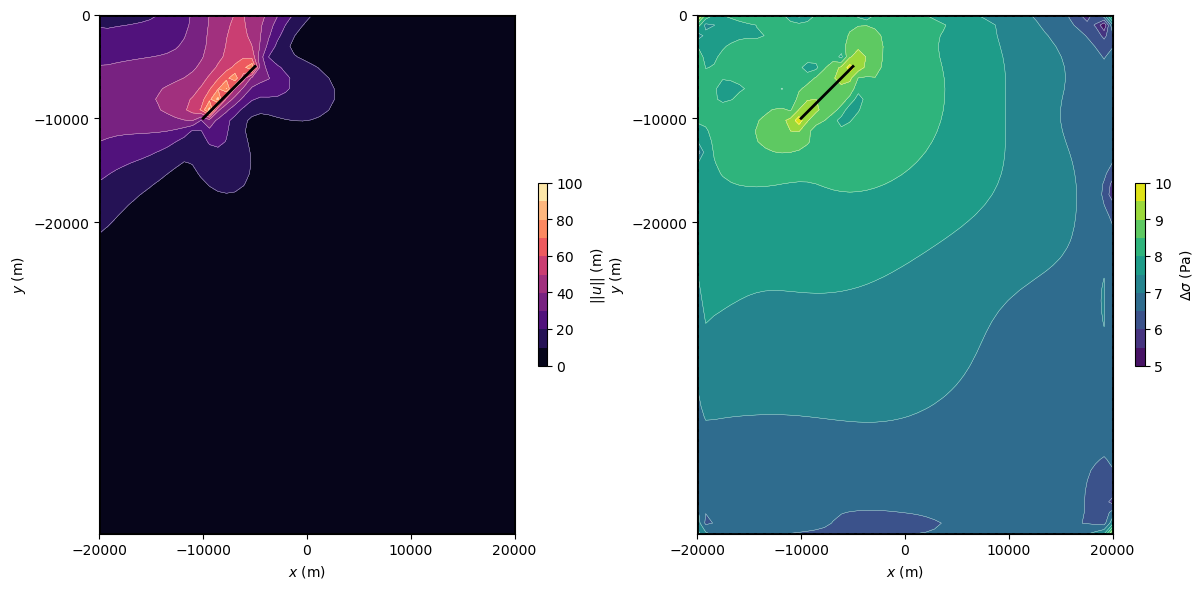

In [14]:
Ueff_fault_only = THbox \ bcs_fault_only
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueff_fault_only[1:2:end], Ueff_fault_only[2:2:end], mu, nu)
UF, SF = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, idx["F"],
                         Fslip[1:2:end], Fslip[2:2:end], mu, nu)
Ufaultonly = UTB .+ UF
Sfaultonly = STB .+ SF
twopanel(xgrid, ygrid, npts, Ufaultonly, Sfaultonly, idx, elsbox, figsize=(12,6), ylim=[B,T]);

TODO LIST:

* Solve the FEM problem with V as body force.
* Set up time stepping.
* Solve the singularity issues near the BEM mesh degrees of freedom.

In [18]:
fenics_mesh = RectangleMesh(Point((L - 5000, T + 5000)), Point((R + 5000, B - 5000)), 100, 100)
scalar_fs = FunctionSpace(fenics_mesh, "P", 1)
vector_fs = VectorFunctionSpace(fenics_mesh, "P", 2) # TODO: can i make this order = 1?
tensor_fs = FunctionSpace(FEniCS.fenics.TensorFunctionSpace(fenics_mesh.pyobject, "P", 1))

"FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}))"

In [60]:
Ueff = Ueff_fault_only;
x_dofs = py"lambda x: x.tabulate_dof_coordinates()"(scalar_fs.pyobject);

_, stress_from_ueff = constdispstress(slip2dispstress, x_dofs[:,1], x_dofs[:,2], elsbox, BRTL_idx,
                                      Ueff[1:2:end], Ueff[2:2:end], mu, nu)

# set stress_from_ueff values to zero when they are outside the box domain.
stress_from_ueff[x_dofs[:,1] .<= L, :] .= 0
stress_from_ueff[x_dofs[:,1] .>= R, :] .= 0
stress_from_ueff[x_dofs[:,2] .<= B, :] .= 0
stress_from_ueff[x_dofs[:,2] .>= T, :] .= 0

fenics_stress_dofs = zeros(4,size(x_dofs)[1])
fenics_stress_dofs[1,:] = stress_from_ueff[:,1]
fenics_stress_dofs[2,:] = stress_from_ueff[:,3]
fenics_stress_dofs[3,:] = stress_from_ueff[:,3]
fenics_stress_dofs[4,:] = stress_from_ueff[:,2];
sigma = FeFunction(tensor_fs)
py"lambda x, vs: x.vector().set_local(vs)"(sigma.pyobject, reshape(fenics_stress_dofs, (:)))

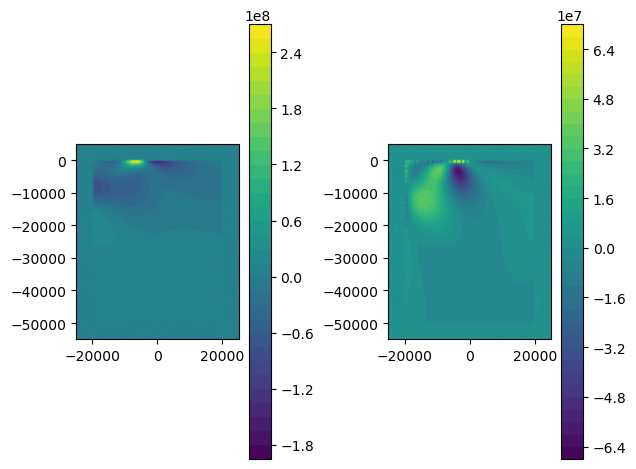

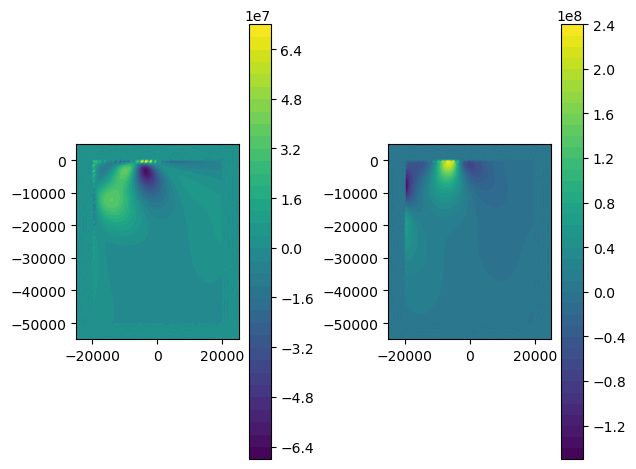

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [61]:
fenics_plot_vec2d(FEniCS.dot(sigma, Constant((1.0, 0.0))))
fenics_plot_vec2d(FEniCS.dot(sigma, Constant((0.0, 1.0))))

In [62]:
# no viscous behavior in the surface layer, mu/eta below VE_z
# We can't use a threshold for eta because we divide by eta and dividing by zero is bad.
fenics_mu_over_eta = interpolate(Expression("0.0 + mu/eta*(x[1] <= VE_z)", degree=0, mu=mu, eta=eta, VE_z=VE_z), scalar_fs)

# https://en.wikipedia.org/wiki/Cauchy_stress_tensor#Stress_deviator_tensor
stress_deviator = sigma - (1.0/3)*FEniCS.tr(sigma)*Identity(2);

dVdt = project(fenics_mu_over_eta * div(stress_deviator), vector_fs)

"Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 821)"

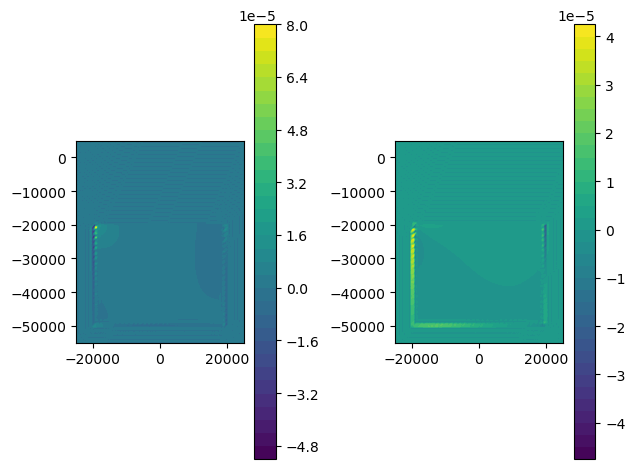

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [63]:
fenics_plot_vec2d(dVdt)

In [ ]:
function calc_dVdt()
    # Step 1: calculate BEM stress
    # Step 2: convert BEM stress to a fenics object
    # Step 3: calculate the stress deviator
    # Step 4: calculate dVdt from the stress deviator.
end